In [1]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Overview

In this notebook, you will learn how to load, explore, visualize, and pre-process a time-series dataset. The output of this notebook is a processed dataset that will be used in following notebooks to build a machine learning model.

### Dataset

[CTA - Ridership - Daily Boarding Totals](https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97): This dataset shows systemwide boardings for both bus and rail services provided by Chicago Transit Authority, dating back to 2001.

### Objective

The goal is to forecast future transit ridership in the City of Chicago, based on previous ridership.

## Install packages and dependencies

Restarting the kernel may be required to use new packages.

In [2]:
%pip install -U statsmodels scikit-learn --user

Note: you may need to restart the kernel to use updated packages.


**Note:** To restart the Kernel, navigate to Kernel > Restart Kernel... on the Jupyter menu.

### Import libraries and define constants

In [3]:
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [7]:
# Enter your project and region. Then run the  cell to make sure the
# Cloud SDK uses the right project for all the commands in this notebook.

PROJECT = 'summer-reef-305107' # REPLACE WITH YOUR PROJECT NAME 
REGION = 'us-west1-b' # REPLACE WITH YOUR REGION e.g. us-central1

#Don't change the following command - this is to check if you have changed the project name above.
assert PROJECT != 'your-project-name', 'Don''t forget to change the project variables!'

In [8]:
target = 'total_rides' # The variable you are predicting
target_description = 'Total Rides' # A description of the target variable
features = {'day_type': 'Day Type'} # Weekday = W, Saturday = A, Sunday/Holiday = U
ts_col = 'service_date' # The name of the column with the date field

raw_data_file = './CTA_-_Ridership_-_Daily_Boarding_Totals.csv'
processed_file = 'cta_ridership.csv' # Which file to save the results to

## Load data

In [28]:
# Import CSV file

from google.cloud import bigquery as bq

sql = """
SELECT
  COUNT(unique_key) as y,
  DATE_TRUNC(DATE(created_date), month) as ds  
FROM `bigquery-public-data.new_york_311.311_service_requests`
GROUP by ds ORDER BY ds asc
"""

client = bq.Client(project=PROJECT)
df = client.query(sql).to_dataframe()

df.head()

# df = pd.read_csv(raw_data_file, index_col=[ts_col], parse_dates=[ts_col])

,y,ds
0,182117,2010-01-01
1,159489,2010-02-01
2,198639,2010-03-01
3,162854,2010-04-01
4,158039,2010-05-01


In [29]:
# Drop duplicates

df = df.drop_duplicates()

In [30]:
# Sort by date

df = df.sort_index()

## Explore data

In [31]:
# Print the top 5 rows

df.head()

,y,ds
0,182117,2010-01-01
1,159489,2010-02-01
2,198639,2010-03-01
3,162854,2010-04-01
4,158039,2010-05-01


### TODO 1: Analyze the patterns

* Is ridership changing much over time?
* Is there a difference in ridership between the weekday and weekends?
* Is the mix of bus vs rail ridership changing over time?

In [32]:
# Initialize plotting

register_matplotlib_converters() # Addresses a warning
sns.set(rc={'figure.figsize':(16,4)})

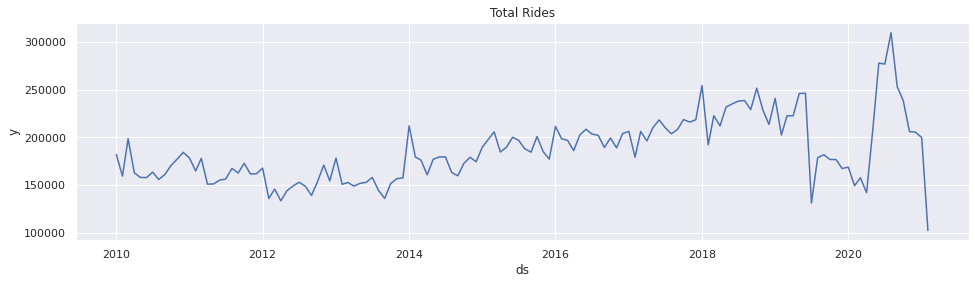

In [33]:
# Explore total rides over time

sns.lineplot(data=df, x=df.ds, y=df.y).set_title('Total Rides')
fig = plt.show()

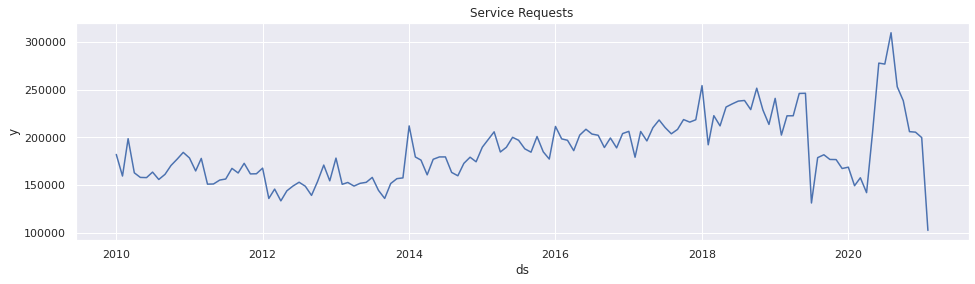

In [42]:
# Explore rides by day type: Weekday (W), Saturday (A), Sunday/Holiday (U)

sns.lineplot(data=df, x=df.ds, y=df.y).set_title('Service Requests')
fig = plt.show()

### TODO 2: Review summary statistics

* How many records are in the dataset?
* What is the average # of riders per day?

In [44]:
df.y.describe().apply(lambda x: round(x))

count       134
mean     186287
std       33800
min      102481
25%      159558
50%      179518
75%      205969
max      309695
Name: y, dtype: int64

### TODO 3: Explore seasonality

* Is there much difference between months?
* Can you extract the trend and seasonal pattern from the data?

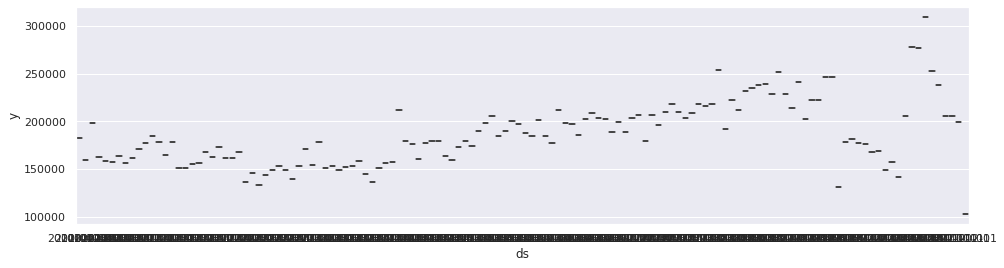

In [55]:
# Show the distribution of values for each month in a boxplot:

months = df.y

fig = sns.boxplot(x=df.ds, y=df.y)

### Auto-correlation

Next, we will create an auto-correlation plot, to show how correlated a time-series is with itself. Each point on the x-axis indicates the correlation at a given lag. The shaded area indicates the confidence interval.

Note that the correlation gradually decreases over time, but reflects weekly seasonality (e.g. `t-7` and `t-14` stand out).

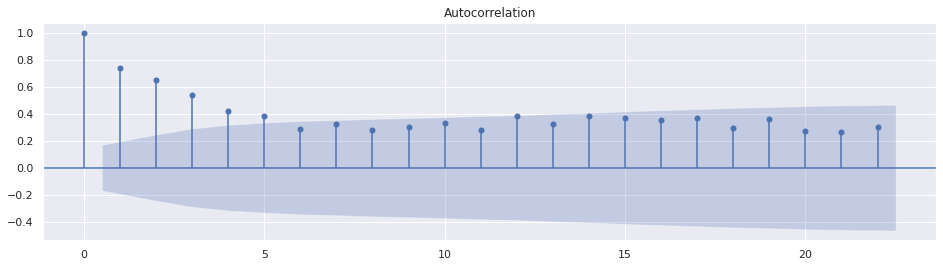

In [58]:
plot_acf(df['y'])

fig = plt.show()

## Export data

This will generate a CSV file, which you will use in the next labs of this quest.
Inspect the CSV file to see what the data looks like.

In [61]:
df[['y']].to_csv('NYC_311_file.csv', index=True, index_label=ts_col)

## Conclusion

You've successfully completed the exploration and visualization lab.
You've learned how to:
* Create a query that groups data into a time series
* Visualize data
* Decompose time series into trend and seasonal components